# Inspect GZ2 Dataset

`gz2_hart16.csv` avaliable at https://data.galaxyzoo.org/

In [6]:
import numpy as np
import pandas as pd

f_sdss = pd.read_csv("gz2_hart16.csv")
print(f"Length of gz2_hart16.csv: {len(f_sdss)}")

Length of gz2_hart16.csv: 239695


In [2]:
# not all GZ2 galaxies are covered by DECals, deleted those entries if not covered

import os
import tqdm

exists_idx = np.ones(len(f_sdss), dtype=bool)

for i in tqdm.tqdm(range(len(f_sdss))):
    if os.path.exists(f"gz2_des/{str(i).rjust(6, '0')}.jpg"):
        pass
    else:
        exists_idx[i] = False
        
print(f"Number of GZ2-SDSS galaxies missing in DECals: {np.sum(~exists_idx)}")

# cutout non-exist DES galaxies (while covered by SDSS)
f_sdss = f_sdss[exists_idx]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 239695/239695 [00:21<00:00, 11170.51it/s]


Number of GZ2-SDSS galaxies missing in DECals: 748


In [3]:
f_sdss.columns.values

array(['dr7objid', 'ra', 'dec', 'rastring', 'decstring', 'sample',
       'gz2_class', 'total_classifications', 'total_votes',
       't01_smooth_or_features_a01_smooth_count',
       't01_smooth_or_features_a01_smooth_weight',
       't01_smooth_or_features_a01_smooth_fraction',
       't01_smooth_or_features_a01_smooth_weighted_fraction',
       't01_smooth_or_features_a01_smooth_debiased',
       't01_smooth_or_features_a01_smooth_flag',
       't01_smooth_or_features_a02_features_or_disk_count',
       't01_smooth_or_features_a02_features_or_disk_weight',
       't01_smooth_or_features_a02_features_or_disk_fraction',
       't01_smooth_or_features_a02_features_or_disk_weighted_fraction',
       't01_smooth_or_features_a02_features_or_disk_debiased',
       't01_smooth_or_features_a02_features_or_disk_flag',
       't01_smooth_or_features_a03_star_or_artifact_count',
       't01_smooth_or_features_a03_star_or_artifact_weight',
       't01_smooth_or_features_a03_star_or_artifact_frac

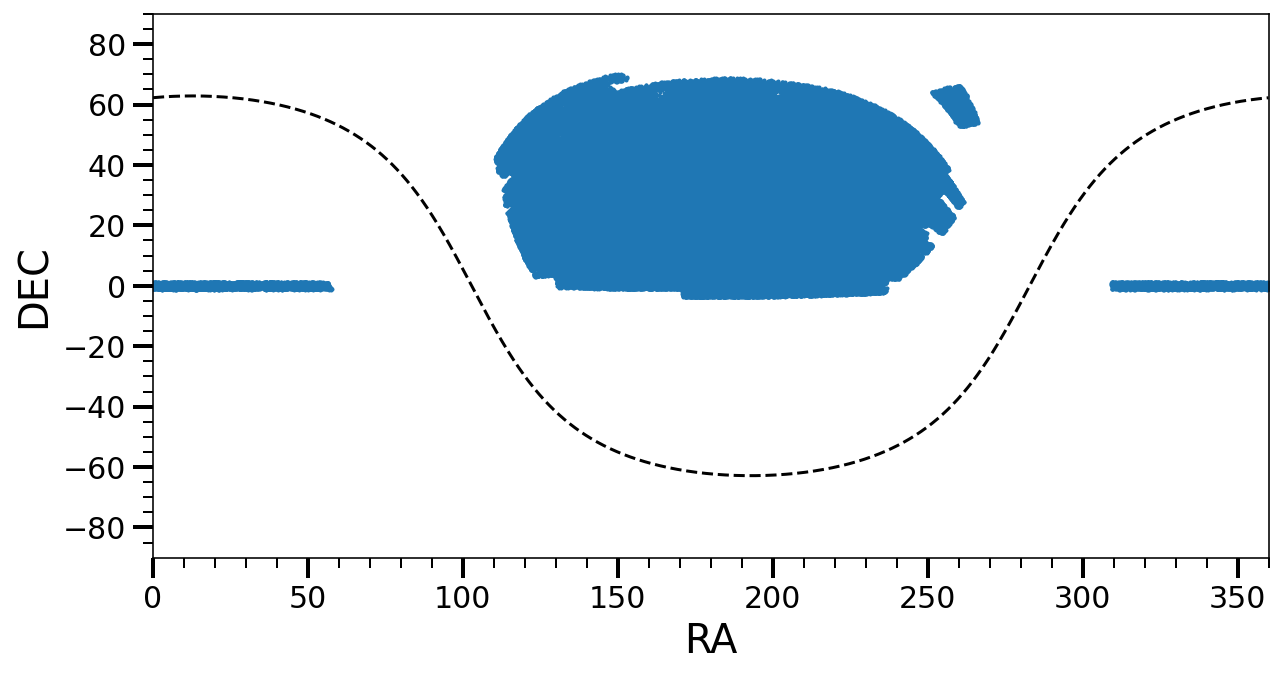

In [3]:
%config InlineBackend.figure_format='retina'

import pylab as plt
from mw_plot import mw_radec

fig = plt.figure(figsize=(10, 5))
ax = fig.gca()
ax.scatter(f_sdss['ra'], f_sdss['dec'], s=1)
ra, dec = mw_radec()
ax.plot(ra, dec, c='k', ls='--')
ax.set_xlim(0, 360)
ax.set_ylim(-90, 90)
ax.set_xlabel("RA", fontsize=20)
ax.set_ylabel("DEC", fontsize=20)
ax.minorticks_on()
ax.tick_params(labelsize=15, width=2, length=10, which='major')
ax.tick_params(width=1, length=5, which='minor')

(array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 1.4000e+01,
        4.8000e+01, 1.6400e+02, 4.3700e+02, 1.0130e+03, 2.1990e+03,
        4.3320e+03, 7.2400e+03, 1.1081e+04, 1.5991e+04, 2.1874e+04,
        3.1037e+04, 4.0780e+04, 3.9628e+04, 2.3362e+04, 1.5293e+04,
        9.9360e+03, 6.4690e+03, 3.9080e+03, 2.2850e+03, 1.2250e+03,
        6.7300e+02, 3.6400e+02, 1.9100e+02, 8.5000e+01, 5.3000e+01]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20., 22., 24.,
        26., 28., 30., 32., 34., 36., 38., 40., 42., 44., 46., 48., 50.,
        52., 54., 56., 58., 60., 62., 64., 66., 68., 70.]),
 <BarContainer object of 35 artists>)

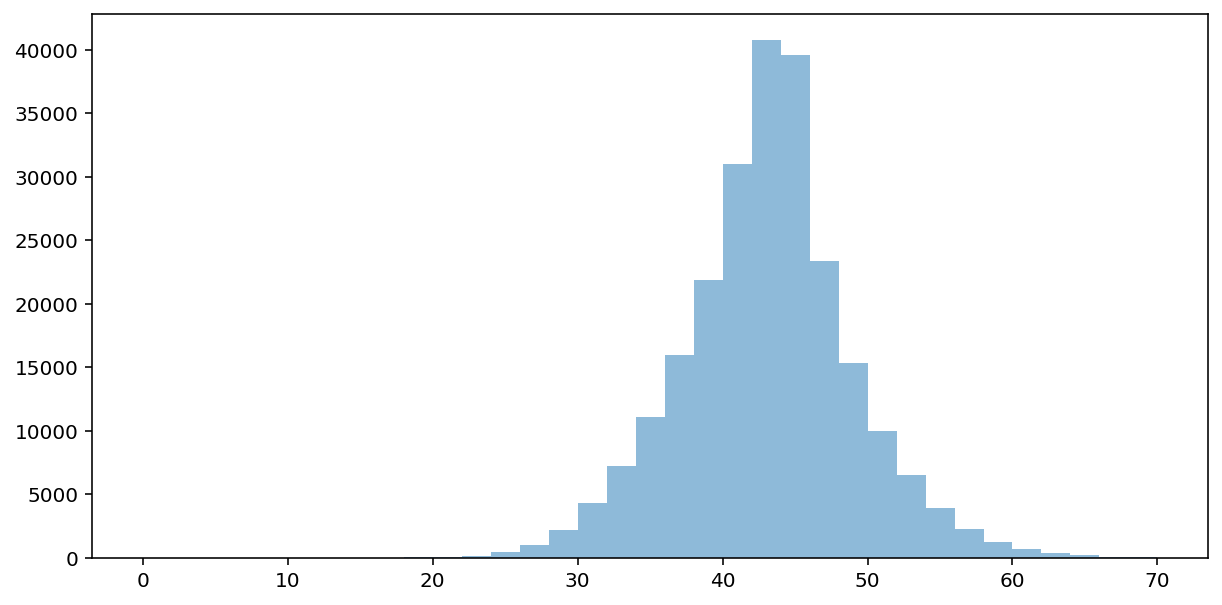

In [12]:
fig = plt.figure(figsize=(10, 5))
ax = fig.gca()
ax.hist(f_sdss["t01_smooth_or_features_a01_smooth_count"]+f_sdss["t01_smooth_or_features_a02_features_or_disk_count"]+f_sdss["t01_smooth_or_features_a03_star_or_artifact_count"], 
        range=(0, 70), bins=35, alpha=0.5)

In [4]:
# cross-matching to see if galaxies are in GZ-DES

from astroNN.datasets.xmatch import xmatch

f_ab = pd.read_csv("gz_decals_volunteers_ab.csv")
ra_ab = f_ab['ra']
dec_ab = f_ab['dec']

f_c = pd.read_csv("gz_decals_volunteers_c.csv")
ra_c = f_c['ra'][~f_c["in_gzd_ab"]]
dec_c = f_c['dec'][~f_c["in_gzd_ab"]]

ra_abc = np.concatenate([ra_ab.to_numpy(), ra_c.to_numpy()])  
dec_abc = np.concatenate([dec_ab.to_numpy(), dec_c.to_numpy()])

idx1, idx2, sep = xmatch(f_sdss['ra'], f_sdss['dec'], ra_abc, dec_abc)
len(idx1)

110964

In [5]:
in_gz_des_abc = np.zeros(len(f_sdss), dtype=bool)
in_gz_des_abc[idx1] = True
f_sdss["in_gz_des_abc"] = in_gz_des_abc
f_sdss.to_csv("gz2_hart16_modded.csv")